## Observations

Month is not a useful variable. Try Quarter.
Best result so far is decision tree with df[['Exterior Wall', 'Fixtures', 'Neighborhood', 'Story Height', 'Assessment Ratio', 'Quarter']]

Lots of outliers here, try RandomForest

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
%matplotlib inline
sns.set(style='darkgrid')
import matplotlib.dates as mdates

In [13]:
df1=pd.read_csv('nashville_20190813150235.csv', parse_dates = ['Most Recent Sale Date', 'Sale Date'], dtype={'Zone': str, 'Neighborhood': str})

C:\Users\alehe\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [36]:
df.columns

Index(['Unnamed: 0', 'Assessment Classification*', 'Assessment Improvement',
       'Assessment Land', 'Assessment Total', 'Assessment Year', 'Baths',
       'Beds', 'Building Condition', 'Building Grade', 'Building Type',
       'Current Owner', 'Deed Reference', 'Exterior Wall', 'Fixtures',
       'Foundation Type', 'Frame Type', 'Half Bath', 'Improvement Value',
       'Land Area', 'Land Value', 'Location', 'Mailing Address',
       'Map & Parcel', 'Most Recent Sale Date', 'Most Recent Sale Price',
       'Neighborhood', 'Number of Living Units', 'Roof Cover', 'Rooms',
       'Square Footage', 'Story Height', 'Tax District',
       'Total Appraisal Value', 'Year Built', 'Zone', 'Parcel ID', 'Land Use',
       'Property Address', 'Suite/ Condo   #', 'Property City', 'Sale Date',
       'Sale Price', 'Legal Reference', 'Sold As Vacant',
       'Multiple Parcels Involved in Sale', 'Assessment Improvement Improved',
       'Most Recent Sale Price Improved', 'Improvement Value Improved',

In [40]:
#Creating new dataframe without duplicate entires
df=df1.sort_values(by='Sale Date').drop_duplicates(subset='Map & Parcel', keep = 'last')
#Dropping parcels that were involved in multi-parcel sales
#Want to create a new column which is the mean sale price per square foot of a parcel in that neighborhood
df['PPS']=df['Sale Price']/df['Square Footage Improved']
df['PPS']=df['PPS'].replace(np.inf, np.nan)
meanpps=df.groupby('Neighborhood')['PPS'].mean().to_frame().rename(columns={'PPS':'NeighborhoodPPS'})
df=df.merge(meanpps, how='left', left_on = 'Neighborhood',right_index=True)
df=df[df['Multiple Parcels Involved in Sale'] == 'No']
df['Assessment Ratio'] = df['Assessment Improvement Improved'] / df['Assessment Total Improved']
df['Month']= df['Sale Date'].dt.month
df['Quarter'] = df['Sale Date'].dt.quarter
#df = df[(df.Neighborhood != '9527') & (df.Neighborhood != '9026')]

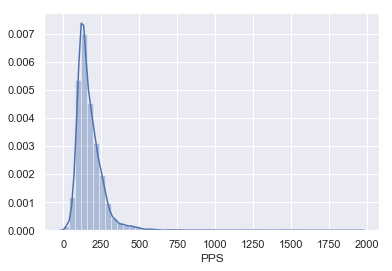

In [41]:
df=df[df.PPS <= 2000]
sns.distplot(df['PPS'].dropna())

In [57]:
#df.nlargest(20, 'PPS')['Neighborhood']

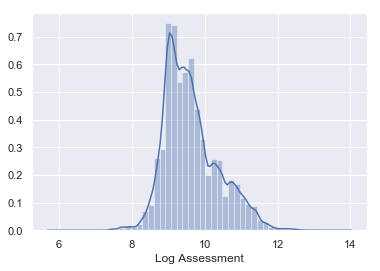

In [45]:
df['Log Assessment']= df['Assessment Land Improved'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log Assessment']=df['Log Assessment'].replace(np.inf, np.nan)
sns.distplot(df['Log Assessment'].dropna())

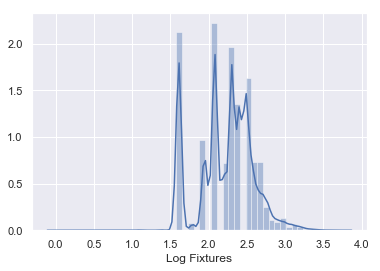

In [46]:
df['Log Fixtures']= df['Fixtures'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log Fixtures']=df['Log Fixtures'].replace(np.inf, np.nan)
sns.distplot(df['Log Fixtures'].dropna())

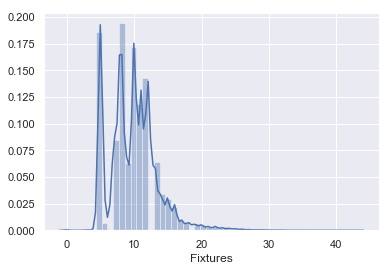

In [47]:
sns.distplot(df['Fixtures'].dropna())

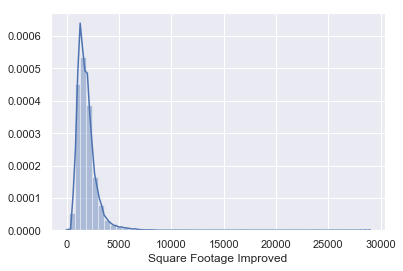

In [10]:
sns.distplot(df['Square Footage Improved'].dropna())

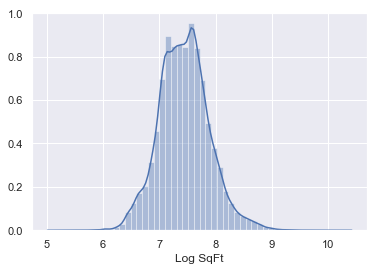

In [48]:
df['Log SqFt']= df['Square Footage Improved'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log SqFt']=df['Log SqFt'].replace(np.inf, np.nan)
sns.distplot(df['Log SqFt'].dropna())

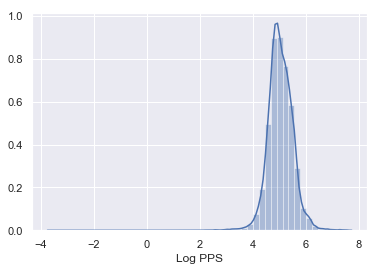

In [49]:
df['Log PPS']= df['PPS'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log PPS']=df['Log PPS'].replace(np.inf, np.nan)
sns.distplot(df['Log PPS'].dropna())

In [58]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.model_selection import train_test_split

In [50]:
df2 = df[['Exterior Wall','Log Fixtures','Building Type Custom', 'Log SqFt', 'Neighborhood', 'Log PPS', 'Log Assessment', 'Quarter']].dropna()
X= pd.get_dummies(df2[['Exterior Wall', 'Neighborhood','Building Type Custom', 'Log Fixtures','Log SqFt', 'Log Assessment', 'Quarter']])
y=df2['Log PPS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.28, random_state=42)

In [12]:
df2.shape

(53968, 8)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = DTR()
dtr=model.fit(X_train, y_train)
y_pred= dtr.predict(X_test)
print(MSE(y_pred, y_test)**0.5)

0.35843075463661306


In [53]:
y_test.mean()

5.035220140183057

In [178]:
from sklearn.neighbors import KNeighborsRegressor as KNN
model= KNN(n_neighbors=20)
knn=model.fit(X_train,y_train)
y_pred=knn.predict(X_test)
print(MSE(y_pred, y_test)**0.5)

0.3084929121077577


In [54]:
from sklearn.ensemble import RandomForestRegressor as RFR
model = RFR(random_state=42)
rfr=model.fit(X_train,y_train)
y_pred=rfr.predict(X_test)
result= MSE(y_test,y_pred)**0.5
print(result)

C:\Users\alehe\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.29287753890054335


In [55]:
np.exp(result)

1.3402786483845195

### GridSearchCV didn't get as good results as untuned RandomForest.

In [25]:
# Number of trees in random forest
n_estimators = [100,200]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [4,5,6]
# Minimum number of samples required to split a node
min_samples_split = [3, 5, 8]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }

In [26]:
from sklearn.model_selection import GridSearchCV
rfgrid = GridSearchCV(estimator = model, param_grid = random_grid, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_r = rfgrid.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 27.8min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 37.8min finished


In [28]:
rfgrid.best_params_

{'max_depth': 6,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 3,
 'n_estimators': 100}

In [33]:
rfgrid.best_score_ 

0.5895567302177649

In [56]:
np.exp(rfgrid.best_score_ )

1.8031889390507527